<a href="https://colab.research.google.com/github/MiguelAngel-ht/MiguelAngel-ht/blob/main/XGBoost_SVR_PROPHET_RANDOMFOREST_WITH_KFOLD_SPLIT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES**

In [1]:
import numpy as np                       # BASIC LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime

In [2]:
from xgboost import XGBClassifier             # IMPORT MODELS
from sklearn.svm import SVR
from prophet import Prophet

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Perceptron

In [3]:
from sklearn.model_selection import KFold      # TO SPLIT DATA
from sklearn.pipeline import make_pipeline                        # TO REGRESSION MODEL
from sklearn.preprocessing import StandardScaler

In [4]:
# METRICS TO EVALUATE MODELS

from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, auc, mean_absolute_error

In [5]:
# DATES TO ADD IN DATAFRAME
datelist = pd.date_range(start="2021-09-11",end="2022-03-02").to_pydatetime().tolist()

# **FUNCTIONS**

In [6]:
# FUNCTION TO SEPARATE DATAFRAME IN ONE COLUMN AND OTHER IS THE REST

def separate(df,column):
  simple = pd.DataFrame(df[column])
  rest = df.loc[:, df.columns != column] 
  return rest, simple 

# TO PLOT ROC 

def ploting(fpr,tpr, roc_auc, model,train,test):

  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))

  ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax1.plot([0, 1], [0, 1],'r--')
  ax1.legend(loc = 'lower right')
  ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate',
          title='Receiver Operating Characteristic -- '+model,
          xlim=[0, 1], ylim = [0, 1.1])
  
  ax2.bar(['Training','Test'],[train,test],color = ['purple', 'orange'])
  ax2.set_ylabel('Amount of data')
  plt.show()

# TO OBTAIN DATA TO PLOT ROC

def roc_param(y_test, y_pred):
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

# **READ DATASET**

In [7]:
file_name = 'ml_test.csv'
df = pd.read_csv(file_name)
df.head(4)                            # PRINT EXAMPLE

,Category 1,Category 2,Service Level %,ABN %,Calls Abn,ASA (secs),Seat at Peak,Occupancy %,on_goal_sl,lr_binary
0,Cat 2,Cat 2.4,0.455362,0.048072,91,91,80,0.899547,no_goal,0
1,Cat 2,Cat 2.3,0.981096,0.010397,11,5,71,0.581073,yes_goal,1
2,Cat 3,Cat 2.5,0.076168,0.127185,713,299,190,0.955376,no_goal,0
3,Cat 3,Cat 2.1,0.836756,0.009754,38,19,209,0.847663,yes_goal,1


In [8]:
df.info()  # VERIFY IF THERE ARE MISSING VALUES

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category 1       173 non-null    object 
 1   Category 2       173 non-null    object 
 2   Service Level %  173 non-null    float64
 3   ABN %            173 non-null    float64
 4   Calls Abn        173 non-null    int64  
 5   ASA (secs)       173 non-null    int64  
 6   Seat at Peak     173 non-null    int64  
 7   Occupancy %      173 non-null    float64
 8   on_goal_sl       173 non-null    object 
 9   lr_binary        173 non-null    int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 13.6+ KB


In [9]:
# SELECT DATA FOR TRAINING AND TESTING

df['Date'] = datelist                        # ADD COLUMN OF DATE TO PROPHIT MODEL
column_name = 'lr_binary'           # LABELS COLUMN
X, y = separate(df,column_name)

# **K FOLD SPLIT**

In [10]:
kf = KFold(n_splits=5,shuffle =True,random_state=4)
X = X.drop(['Category 1','Category 2','on_goal_sl','Date'],axis=1).to_numpy()    # CLEAN DATASET 
y = y.to_numpy()
for train_index, test_index in kf.split(X):              # SPLIT DATA INTO TRAIN AND TEST
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [11]:
len(X_train)/len(X_test)

4.088235294117647

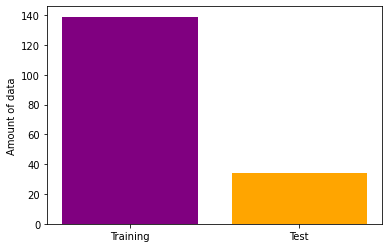

In [12]:
# PROPORTION OF TRAINING AND TEST DATA

plt.bar(['Training','Test'],[len(X_train),len(X_test)],color = ['purple', 'orange'])
plt.ylabel('Amount of data')
plt.show()

# **XGBOOST MODEL**

In [13]:
model = XGBClassifier()                     # MODEL OF SGBOOST
model.fit(X_train, y_train.ravel())  # ravel() to change (shape: (n,1)) to (n,) 

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 100.00%
Precision: 100.00%


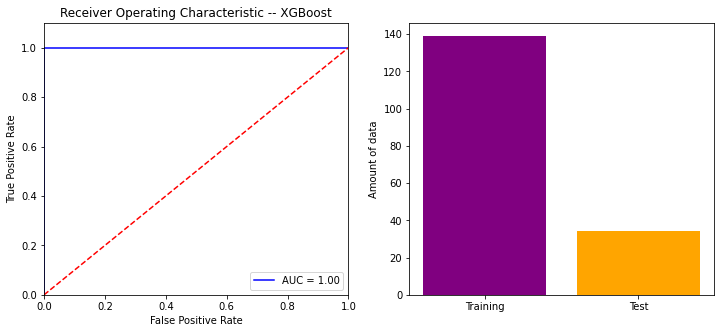

In [14]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'XGBoost',len(X_train),len(X_test))

# **SVR MODEL**

In [15]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))  # MODEL OF SVR
regr.fit(X_train, y_train.ravel())

y_pred = regr.predict(X_test)
y_pred = [round(values) for values in y_pred]        # ROUND VALUES TO BINARY SET

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 91.18%
Precision: 86.36%


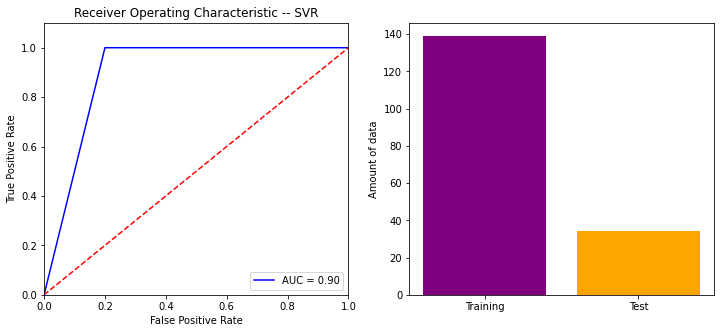

In [16]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'SVR',len(X_train),len(X_test))

# **PROPHIT MODEL**

In [17]:
# SIMULATE DATASET

COLUMN_NAME = df.columns[6]          # COLUMN TO PREDICT    range--> 2-7
DF = df.drop(df.index[125:172])[['Date',COLUMN_NAME]]
DF.columns = ['ds','y']       # NAMES TO THE MODEL WORKS 
DF.head(4)

,ds,y
0,2021-09-11,80
1,2021-09-12,71
2,2021-09-13,190
3,2021-09-14,209


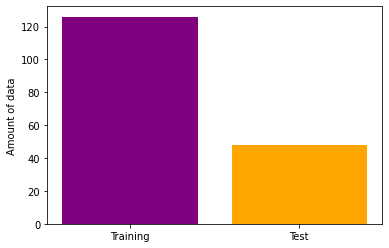

In [18]:
# PROPORTION OF TRAINING AND TEST DATA

plt.bar(['Training','Test'],[len(DF),len(df.drop(df.index[0:125]))],color = ['purple', 'orange'])
plt.ylabel('Amount of data')
plt.show()

In [19]:
# PROPHET MODEL
m = Prophet(interval_width=0.92, daily_seasonality=True)
m.fit(DF)

# create forecast

future = pd.DataFrame(df.drop(df.index[0:125])['Date'])
future.columns = ['ds']
forecast = m.predict(future)


01:10:13 - cmdstanpy - INFO - Chain [1] start processing
01:10:13 - cmdstanpy - INFO - Chain [1] done processing


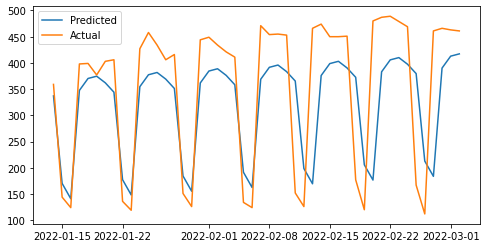

In [20]:
plt.figure(figsize=(8,4))

plt.plot(future,forecast['yhat'],label='Predicted' )
plt.plot(future, df.drop(df.index[0:125])[COLUMN_NAME],label='Actual')
plt.legend()
plt.show()

In [21]:
mae = mean_absolute_error(df.drop(df.index[0:125])[COLUMN_NAME].values,
                          forecast['yhat'].values)

print('MAE: %.3f' % mae)   # It is the difference between the measured value and “true” value.

MAE: 80.839


# **RANDOM FOREST**

In [22]:
clf = RandomForestClassifier(max_depth=2, random_state=0)     # RANDOM FOREST MODEL
clf.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 97.06%
Precision: 95.00%


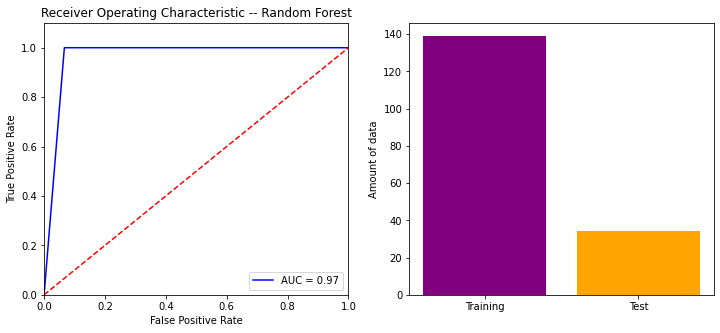

In [23]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'Random Forest',len(X_train),len(X_test))

# **KNN**

In [24]:
neigh = KNeighborsClassifier(n_neighbors=3)    # K-NEAREST NEIGHBOORS MODEL
neigh.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 97.06%
Precision: 95.00%


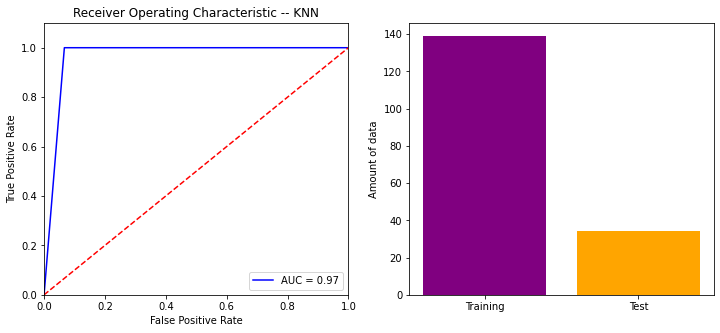

In [25]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'KNN',len(X_train),len(X_test))

# **MULTIPLE REGRESSION**

In [26]:
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)    # LINEAL MULTI VARIABLE REGRESSION MODEL
regr.predict(X_test)

y_pred = clf.predict(X_test)
y_pred = [round(values) for values in y_pred]        # ROUND VALUES TO BINARY SET

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 97.06%
Precision: 95.00%


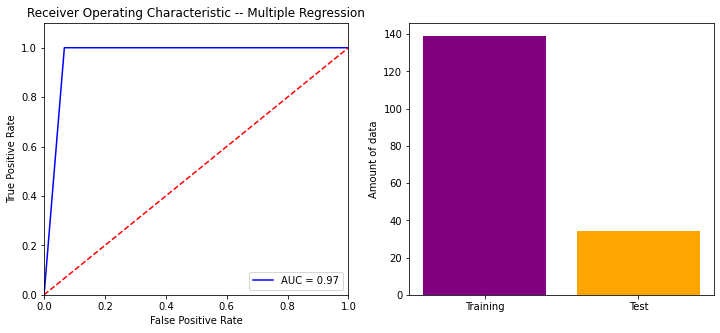

In [27]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'Multiple Regression',len(X_train),len(X_test))

# **PERCEPTRON**

In [28]:
clf = Perceptron(tol=1e-3, random_state=3)       # PRECEPTRON MODEL
clf.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 82.35%
Precision: 76.00%


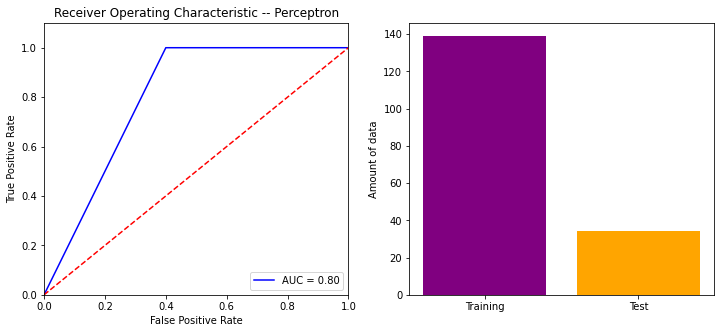

In [29]:
fpr, tpr, roc_auc = roc_param(y_test, y_pred)
ploting(fpr,tpr, roc_auc, 'Perceptron',len(X_train),len(X_test))